In [ ]:
# ALle notwendigen Bibliotheken laden
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

## Datenmanagement

In [ ]:
# Daten mit vorgefertigtem Split laden
(ds, ds_test), info = tfds.load('stl10', split=['train','test'], shuffle_files = False, as_supervised= True, with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/stl10/1.0.0.incompleteLIJVEO/stl10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/stl10/1.0.0.incompleteLIJVEO/stl10-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/stl10/1.0.0.incompleteLIJVEO/stl10-unlabelled.tfrecord


Dataset stl10 downloaded and prepared to /root/tensorflow_datasets/stl10/1.0.0. Subsequent calls will reuse this data.


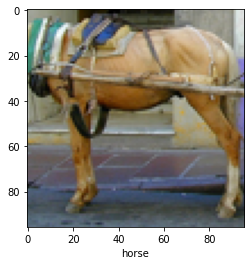

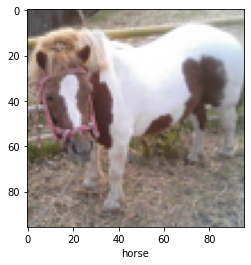

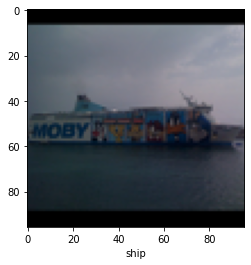

In [ ]:
# Labels wurden der zum Datensatz gehörigen Webseite entnommen
labels = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

# Drei zufällige Bilder ausgeben
image = ds.take(1000).shuffle(1000).take(3)
for img, lbl in tfds.as_numpy(image):
  plt.imshow(img)
  plt.xlabel(labels[lbl])
  plt.show()

## Daten anpassen

In [ ]:
# Eigene Funktion, um Bilder zu normalisieren
def normalisiere_img(image, label):
  return tf.cast(image, tf.float32) / 255., label

In [ ]:
# Eigene Funktion, für das Labelencoding
def encode_label(image, label): 
  return img, tf.one_hot(label, 10)

In [ ]:
# Traindatensatz vorbereiten
ds_train = ds.map(normalisiere_img, num_parallel_calls = tf.data.experimental.AUTOTUNE)
#ds_train = ds_train.map(encode_label, num_parallel_calls = tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(info.splits['train'].num_examples) 
ds_train = ds_train.batch(100) # Batchsize von 100
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# Testdatensatz vorbereiten
ds_test_prepared = ds_test.map(normalisiere_img, num_parallel_calls = tf.data.experimental.AUTOTUNE)
#ds_test_prepared = ds_test_prepared.map(encode_label, num_parallel_calls = tf.data.experimental.AUTOTUNE)
ds_test_prepared = ds_test_prepared.batch(100) # Batchsize von 100
ds_test_prepared = ds_test_prepared.cache() 
ds_test_prepared = ds_test_prepared.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# 3 zufällige Batches aus dem vorbereiteten Trainingsdatensatz zum Testen ausgeben
for elem, label in ds_train.take(3):
  print(label)

tf.Tensor(
[8 2 9 7 2 7 4 0 8 9 4 8 6 8 7 6 7 3 6 3 4 6 6 2 6 4 7 5 3 7 5 8 0 7 5 3 9
 5 6 7 2 3 5 6 4 6 0 9 5 7 8 1 7 2 6 2 0 9 9 5 0 6 0 1 6 2 1 9 9 5 3 5 0 6
 6 1 2 0 5 0 2 1 1 9 6 8 8 0 7 9 6 3 9 8 2 0 5 5 8 3], shape=(100,), dtype=int64)
tf.Tensor(
[7 4 1 6 8 4 1 8 0 8 3 0 6 6 1 3 6 9 4 0 7 9 2 1 5 3 2 4 6 8 6 4 2 8 5 1 5
 5 2 8 0 9 6 6 7 8 4 1 3 5 3 3 0 9 7 7 5 3 4 0 4 5 4 8 9 8 8 1 9 1 2 2 2 2
 1 2 0 0 2 6 7 8 5 2 1 5 5 7 4 6 1 1 3 7 4 2 5 2 0 0], shape=(100,), dtype=int64)
tf.Tensor(
[9 3 4 4 7 0 4 7 7 0 1 6 3 7 9 6 4 6 3 1 4 7 7 4 1 2 8 5 2 6 7 1 8 8 9 9 7
 5 2 1 4 6 6 9 8 8 5 2 0 8 9 7 3 5 3 8 7 0 5 0 5 0 8 5 9 8 8 1 8 0 0 9 8 1
 2 4 4 9 3 2 4 3 0 9 9 8 8 8 5 3 0 4 7 2 7 9 4 5 3 1], shape=(100,), dtype=int64)


In [ ]:
# Shape und Typ des Testdatensatzes ausgeben
ds_test_prepared

<PrefetchDataset shapes: ((None, 96, 96, 3), (None,)), types: (tf.float32, tf.int64)>

## Modelldesign

In [ ]:
# Model erstellen
model = tf.keras.models.Sequential([
  tf.keras.Input(shape = (96, 96, 3)),
  tf.keras.layers.AveragePooling2D(pool_size = (2, 2), strides = (2, 2)),
  tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
  tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
  tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
  tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])


In [ ]:
# Zusammenfassung des Models ausgeben
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d (AveragePo (None, 48, 48, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0

### Begründung der Komponentenauswahl
Zu Beginn des Netzes wurde ein Avg.-Pooling Layer verwendet um die Dimension des Eingabebilds zu reduzieren.

Auf das Avg.-Pooling folgen drei Convolutional-Blöcke.
Diese bestehen jeweils aus folgenden drei Schichten:
1. Convolutional Layer
2. Max-Pooling Layer
3. Dropout Layer

Der Max-Pooling Layer wird verwendet um die Eingabedimension zwischen den Convolutional-Blöcken zu verringern. Dies soll eine höhere Effizienz des Netzes erzielen.

Mit dem Dropout-Layer kann eine schnelle Überanpassung des Modells verhindert werden.

Nach den Convolutional-Blöcken wird ein Dense Layer verwendet um die Informationsgewinnung innerhalb des Netzes zu ermöglichen.

Das letzte Dense Layer mit der Dimension 10 wird verwendet um die Ergebnisse des vorherigen Dense Layers auf die 10 zu unterscheidenden Klassen abzubilden.

## Training

In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy', # Sparse Categorical, da Labels kategorisch sind aber in einem Dezimalwert kodiert sind.
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

In [ ]:
# Callback einrichten, wenn 'val_loss'-Kurve 2 Epochen hintereinander steigt
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
# History beim Ausführen direkt speichern, zur Erstellung einer Lernkurve
history = model.fit(
    ds_train,
    epochs=30,
    validation_data = ds_test_prepared,
    callbacks = [callback]
)

Epoch 1/30
50/50 [==============================] - 52s 1s/step - loss: 2.0498 - accuracy: 0.2426 - val_loss: 1.8235 - val_accuracy: 0.3335
Epoch 2/30
50/50 [==============================] - 59s 1s/step - loss: 1.6521 - accuracy: 0.3850 - val_loss: 1.5975 - val_accuracy: 0.4330
Epoch 3/30
50/50 [==============================] - 55s 1s/step - loss: 1.5085 - accuracy: 0.4406 - val_loss: 1.5504 - val_accuracy: 0.4254
Epoch 4/30
50/50 [==============================] - 56s 1s/step - loss: 1.4305 - accuracy: 0.4764 - val_loss: 1.4084 - val_accuracy: 0.4734
Epoch 5/30
50/50 [==============================] - 57s 1s/step - loss: 1.3312 - accuracy: 0.5066 - val_loss: 1.3538 - val_accuracy: 0.5002
Epoch 6/30
50/50 [==============================] - 57s 1s/step - loss: 1.2599 - accuracy: 0.5412 - val_loss: 1.2834 - val_accuracy: 0.5275
Epoch 7/30
50/50 [==============================] - 58s 1s/step - loss: 1.1780 - accuracy: 0.5694 - val_loss: 1.2922 - val_accuracy: 0.5222
Epoch 8/30
50/50 [==

## Modellvalidierung und Performancebewertung
Folgend soll anhand des Accuracy- und Loss-Verlaufs die Performance des Modells bewertet werden.

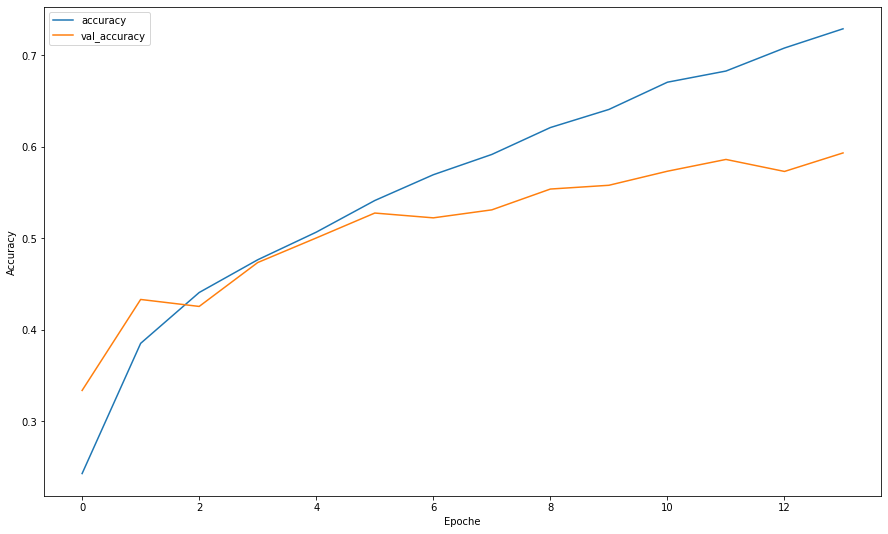

In [ ]:
# Accuracykurven zeichnen
plt.figure(figsize=(15,9))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoche')
plt.ylabel('Accuracy')
plt.legend()

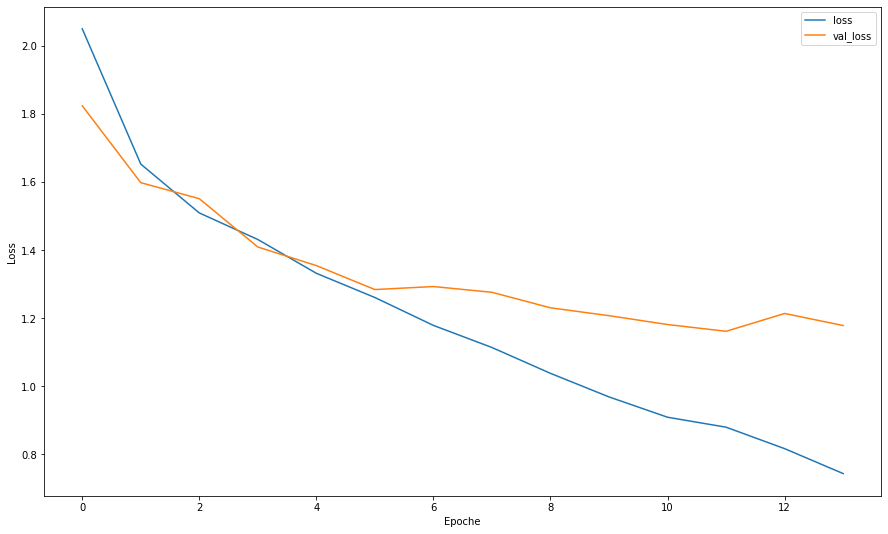

In [ ]:
# Losskurven zeichnen
plt.figure(figsize=(15,9))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.legend()

Wie oben zu sehen overfittet das Modell hier nicht. Man kann davon ausgehen, dass sich das Modell bei längerem Trainieren einem Validierungs-Score von etwa 0,6 annähert.

In [ ]:
# Testbilder laden
ds_unlabelled, info = tfds.load('stl10', split=['test'], shuffle_files = False, as_supervised= True, with_info=True)
ds_unlabelled = ds_unlabelled[0]

['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


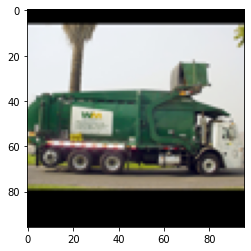

Vorhersage: truck: 65.9%, car: 27.3%, ship: 6.7%, airplane: 0.0%, cat: 0.0%
Tatsächlich: truck




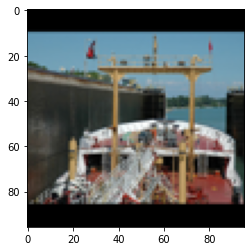

Vorhersage: truck: 72.4%, ship: 11.7%, car: 11.4%, airplane: 4.5%, horse: 0.0%
Tatsächlich: ship




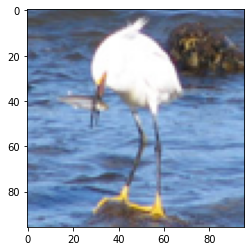

Vorhersage: bird: 95.3%, deer: 1.8%, airplane: 0.8%, dog: 0.6%, ship: 0.6%
Tatsächlich: bird




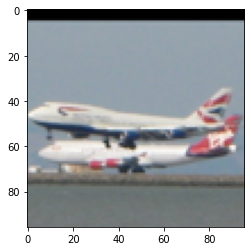

Vorhersage: airplane: 91.9%, ship: 7.2%, truck: 0.9%, car: 0.0%, cat: 0.0%
Tatsächlich: airplane




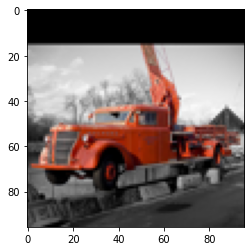

Vorhersage: truck: 94.7%, ship: 5.2%, car: 0.1%, airplane: 0.0%, horse: 0.0%
Tatsächlich: truck




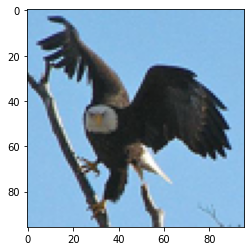

Vorhersage: bird: 88.8%, horse: 5.5%, deer: 3.2%, cat: 0.9%, airplane: 0.7%
Tatsächlich: bird




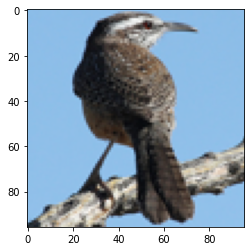

Vorhersage: bird: 48.4%, monkey: 23.4%, cat: 14.5%, dog: 6.8%, airplane: 5.3%
Tatsächlich: bird




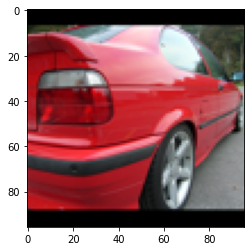

Vorhersage: car: 53.9%, truck: 41.4%, airplane: 4.6%, ship: 0.1%, cat: 0.0%
Tatsächlich: car




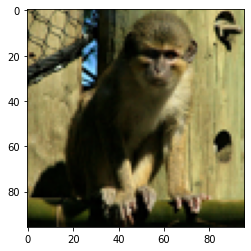

Vorhersage: monkey: 60.9%, cat: 31.8%, bird: 2.9%, deer: 1.8%, dog: 1.5%
Tatsächlich: monkey




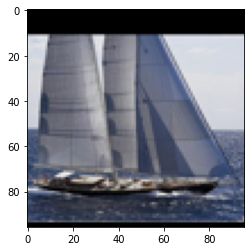

Vorhersage: ship: 77.7%, truck: 16.6%, car: 1.8%, cat: 1.8%, horse: 0.9%
Tatsächlich: ship




In [ ]:
some_images = ds_unlabelled.take(10000).shuffle(10000).take(10)
some_images = some_images.map(normalisiere_img, num_parallel_calls = tf.data.experimental.AUTOTUNE)
print(labels)

# 10 Bilder mit vorhergesagtem Label und tatsächlichem Label ausgeben. Zusätzlich wird bei der Vorhersage die vom Model geschätzte Wahrscheinlichkeit angezeigt 
for (img, lbl) in some_images:
  plt.imshow(img)
  plt.show()
  predictions = model.predict(np.reshape(img, (1, 96, 96, 3)))[0]
  predictions *= 100
  order = np.argsort(predictions)[::-1]
  sorted_predictions = list(zip(np.array(labels)[order], predictions[order]))
  print('Vorhersage:', ', '.join(['{}: {:.1f}%'.format(label, confidence) for label, confidence in sorted_predictions[:5]]))
  print('Tatsächlich:', labels[lbl])
  print('\n')

In [ ]:
# Zum Schluss noch eine Zusammenfassung der Metriken
model.evaluate(ds_test_prepared)

80/80 [==============================] - 25s 319ms/step - loss: 1.1776 - accuracy: 0.5932


[1.1776167154312134, 0.5932499766349792]

Dafür, dass dieses Modell 10 Labels unterscheiden muss, erzielt es eine recht gute Performance. 
Wie in der obigen Beispielvalidierung zu sehen sind Fehlklassifizierungen auch meist nachvollziehbar:  
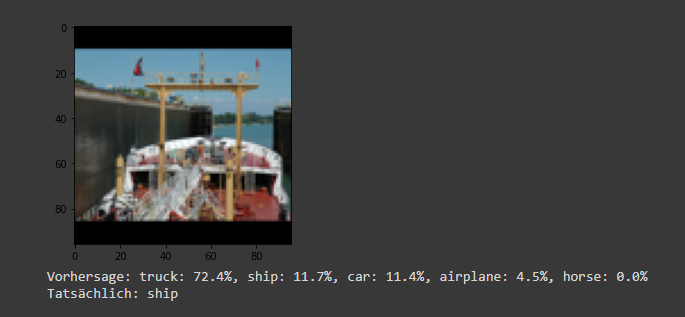